In [22]:
import pandas as pd
from sklearn.manifold import TSNE
import networkx as nx
import numpy as np
from node2vec import Node2Vec
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

In [23]:
# Reading the dataset
df = pd.read_csv('Iron_dealers_data.csv')
df.head()

,Seller ID,Buyer ID,Value
0,1309,1011,1225513.0
1,1309,1011,1179061.0
2,1309,1011,1119561.0
3,1309,1011,1200934.0
4,1309,1011,1658957.0


In [24]:
#Constructing a Directed Multi-graph
G = nx.MultiDiGraph()

for index, row in df.iterrows():
    seller_id = int(row['Seller ID'])
    buyer_id = int(row['Buyer ID'])
    G.add_edge(seller_id, buyer_id, weight=row['Value'])

In [25]:
edges = []
UG = nx.Graph()

# Constructing the undirected graph
for u in G.nodes():
    for v in G.successors(u):
        weight = 1
        w = np.array([2,3,3,4])
        for t in G.successors(v):
            r = np.zeros(4)
            if G.has_edge(t,u):
                # Found a 3 cycle
                reciprocal = 0
                if G.has_edge(v,u):
                    reciprocal+=1
                if G.has_edge(t,v):
                    reciprocal+=1
                if G.has_edge(u,t):
                    reciprocal+=1
                
                r[reciprocal]+=1
                weight = max(weight,np.max(w*r))

        if UG.has_edge(u,v):
            UG[u][v]['weight'] = int(max(weight, UG[u][v]['weight']))
        else:
            UG.add_edge(u,v,weight=int(weight))

In [26]:
# printing the edges to a file to verify the edges
with open('my_model.txt', 'w') as f:
    for edge in UG.edges(data=True):
        f.write(str(edge[0]) + " " + str(edge[1]) + " " + str(edge[2]['weight']) + "\n")

In [27]:
# using node2vec to compute node embeddings
node2vec = Node2Vec(UG,dimensions=32,walk_length=10,num_walks=200,workers=6)
model = node2vec.fit(window = 10,min_count=1, batch_words=4)

Computing transition probabilities:   0%|          | 0/799 [00:00<?, ?it/s]

Generating walks (CPU: 6): 100%|██████████| 33/33 [00:03<00:00, 10.14it/s]


In [28]:
input = np.array([model.wv[str(node)] for node in UG.nodes()])

In [29]:
# Using DBSCAN to cluster the node embeddings
clustering = DBSCAN(eps = 1,min_samples=5).fit(input)
print(np.unique(clustering.labels_))

[-1  0  1  2  3  4  5  6  7  8]


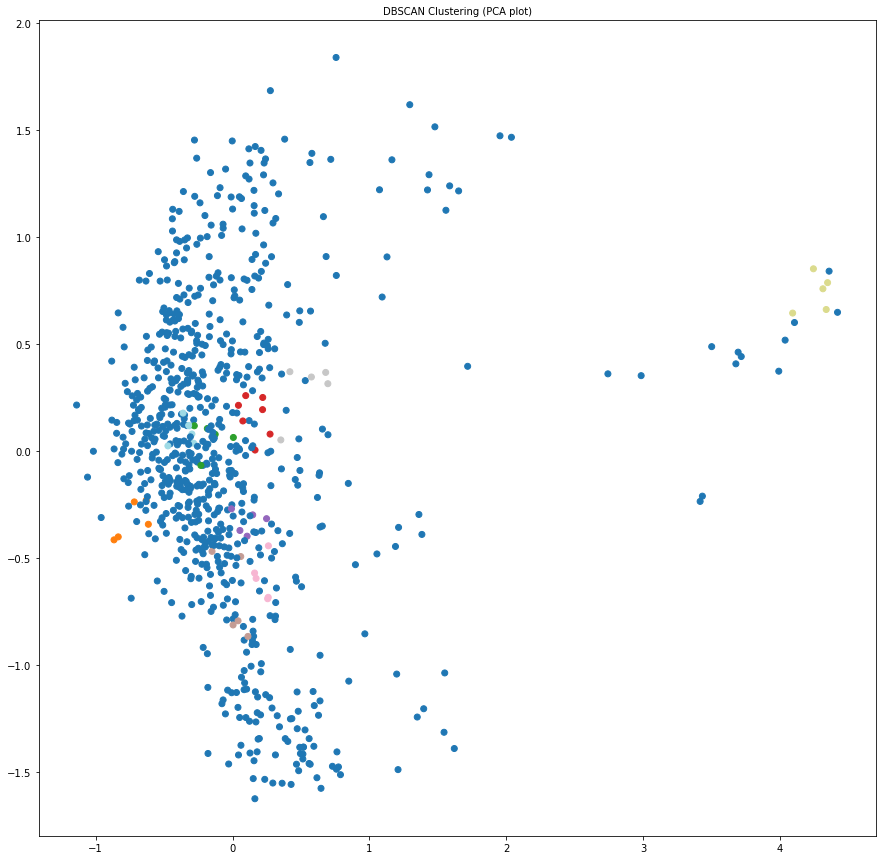

In [35]:
# Using PCA reduce the node embeddings to 2 dimension and plot them
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(input)
input_red = pca.transform(input)

fig, ax = plt.subplots(figsize=(15, 15))
ax.set_title('DBSCAN Clustering (PCA plot)', fontsize=10)
ax.scatter(input_red[:, 0], input_red[:, 1], c=[_ + 1 for _ in clustering.labels_], cmap='tab20')
fig.savefig('pca.png')

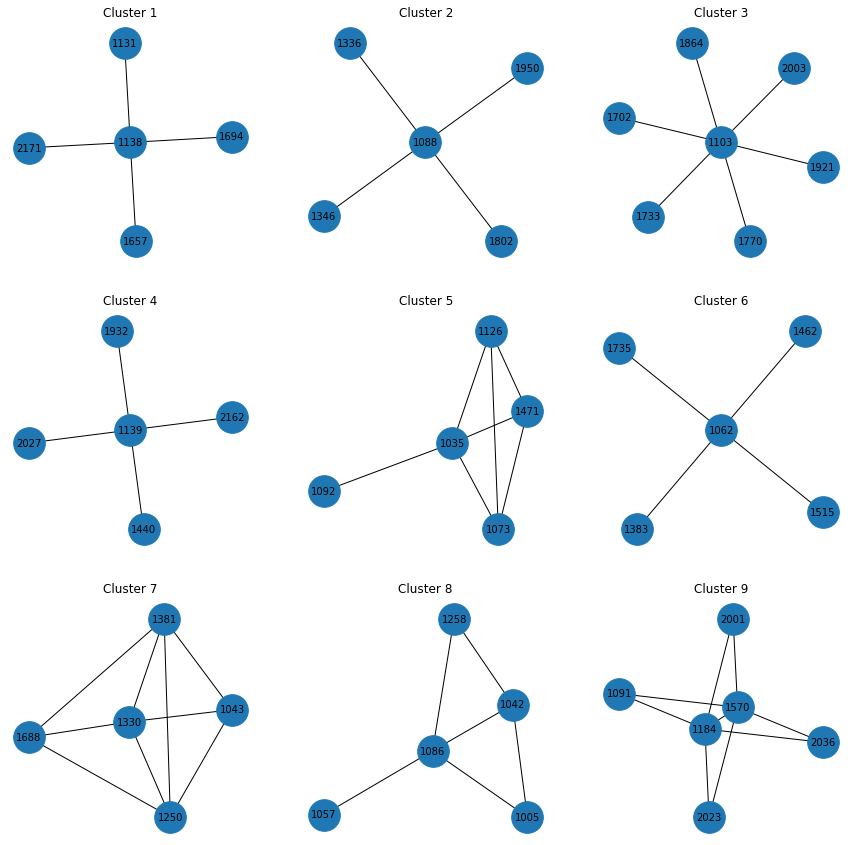

In [31]:
# plotting the nodes in the cluster 
nodes = list(UG.nodes())
fig, ax = plt.subplots(figsize=(15,15), nrows=3, ncols=3)
for label in np.unique(clustering.labels_):
    i = label // 3
    j = label % 3

    if label == -1:
        continue
    idxs = np.where(clustering.labels_ == label)[0]
    subgraph_nodes = [nodes[idx] for idx in idxs]
    
    nx.draw(UG.subgraph(subgraph_nodes), with_labels=True, font_size=10, node_size=1000, ax=ax[i][j])
    ax[i][j].set_title("Cluster " + str(label + 1))

fig.savefig("clusters.png")
